In [1]:
import pandas as pd
import numpy as np

In [2]:
import bitstring

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
import os
import glob
import binascii
import collections
from struct import pack, unpack
from enum import Enum
from typing import NamedTuple

In [5]:
glob.glob(os.path.join('..', 'measurements', 'logic', '24 MHz', '*.csv'))

['../measurements/logic/24 MHz/Both in sight, obstructed (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only B enabled (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only C in sight (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Both in sight (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only B in sight (24 MHz, 240 M Samples).csv']

For the given data sequences, the sensor diode was placed **about 2 m** away from Lighthouse A (measured directly), roughly **1.4 m** to the left (when looking straight at it), as well as **1.5 m** beneath it. Depending on the direction of the sweep, this places the diode either relatively close to the beginning or the end of it.

Likewise, the diode was placed about **1.5 m** to the right of Lighthouse B (when looking straight at it), as well as about **1.7 m** beneath it, and at a distance of 3.5 m (totaling about **4.2 m**).

In [6]:
csv_files = glob.glob(os.path.join('..', 'measurements', 'logic', '24 MHz', 'Both*.csv'))
csv_files

['../measurements/logic/24 MHz/Both in sight, obstructed (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Both in sight (24 MHz, 240 M Samples).csv']

In [7]:
df_src = pd.read_csv(csv_files[1], names=['Time [s]', 'Level'], skiprows=1)
df_src.dtypes

Time [s]    float64
Level         int64
dtype: object

In [8]:
df_src.describe()

,Time [s],Level
count,7143.000000,7143.000000
mean,4.972771,0.499930
std,2.880369,0.500035
min,-0.005241,0.000000
25%,2.480376,0.000000
50%,4.961085,0.000000
75%,7.459203,1.000000
max,9.994849,1.000000


In [9]:
df_src.head(n=8)

,Time [s],Level
0,-0.005241,0
1,0.000000,1
2,0.000075,0
3,0.000419,1
4,0.000530,0
5,0.003090,1
6,0.003104,0
7,0.008333,1


Let's visualize the pulses to see whether the data makes sense at a first glance.

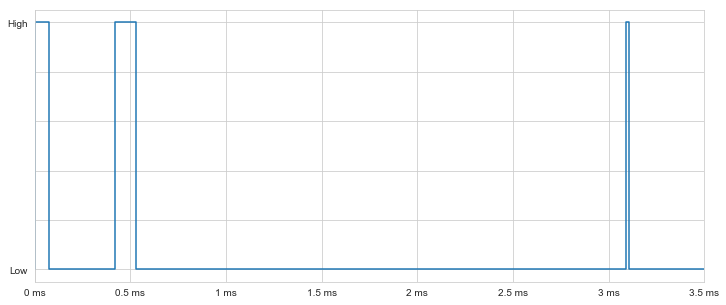

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.0035]);
ax.set_xticklabels(['0 ms', '0.5 ms', '1 ms', '1.5 ms', '2 ms', '2.5 ms', '3 ms', '3.5 ms']);
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

That seems to be fine. Let's look at a longer sequence.

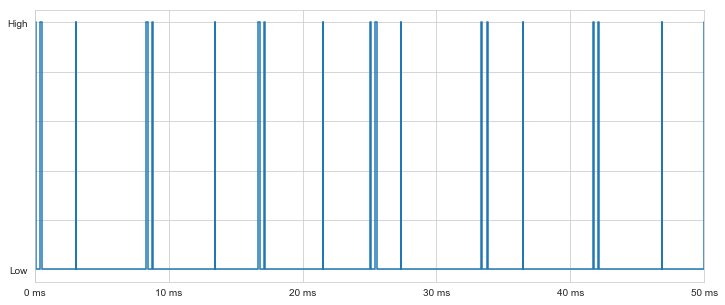

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.05])
ax.set_xticklabels(['0 ms', '10 ms', '20 ms', '30 ms', '40 ms', '50 ms'])
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

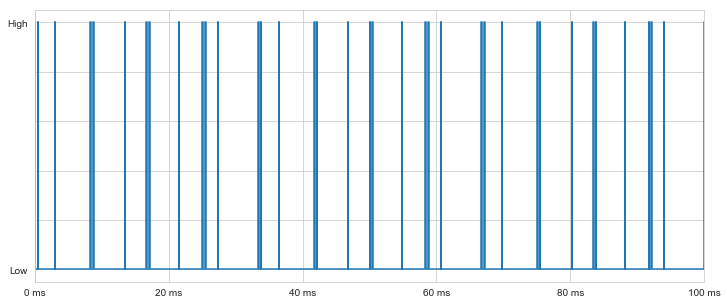

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.1])
ax.set_xticklabels(['0 ms', '20 ms', '40 ms', '60 ms', '80 ms', '100 ms'])
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

Next, we determine the durations of the high and low states by taking the piecewise difference to the next state.

In [13]:
df_durations = (df_src.shift(-1)['Time [s]'] - df_src['Time [s]']).to_frame(name='Duration [s]')
df = df_src.join(df_durations)
df.head(10)

,Time [s],Level,Duration [s]
0,-0.005241,0,0.005241
1,0.000000,1,0.000075
2,0.000075,0,0.000344
3,0.000419,1,0.000111
4,0.000530,0,0.002561
5,0.003090,1,0.000014
6,0.003104,0,0.005228
7,0.008333,1,0.000107
8,0.008439,0,0.000313
9,0.008752,1,0.000059


For further insights, we're going to isolate the High pulses and convert them to microseconds.

In [14]:
def sec_to_us(t: float) -> float:
    return t * 1_000_000

In [15]:
def us_to_sec(t: float) -> float:
    return t / 1_000_000

In [16]:
df_high_filter = df['Level'] > 0
df_high_durations = df.loc[df_high_filter, 'Duration [s]']
df_high_durations_us = sec_to_us(df_high_durations).to_frame(name='Duration [µs]').dropna()

The statistics give that the pulse duration ranges from 0.625 µs to about 137.792 µs:

In [17]:
df_high_durations_us.describe()

,Duration [µs]
count,3571.000000
mean,66.567266
std,46.740835
min,0.458333
25%,14.083333
50%,74.833333
75%,106.583333
max,137.875000


Given the lower and upper boundary for the pulse durations, we can now inspect the histogram.

The dotted magenta lines show the positions of the defined OOTX (Omnidirectional Optical Transmitter) sync pulse lengths at

- 62.5 µs, 
- 72.9 µs, 
- 83.3 µs, 
- 93.8 µs,
- 104 µs,
- 115 µs,
- 125 µs and
- 135 µs.

We can see that the histogram peaks are offset from these expected locations quite noticeably. The dash-dotted magenta line indicates the lower bound for peaks, as described later.

In [18]:
sync_peak_end = np.array([62.5, 72.9, 83.3, 93.8, 104, 115, 125, 135])

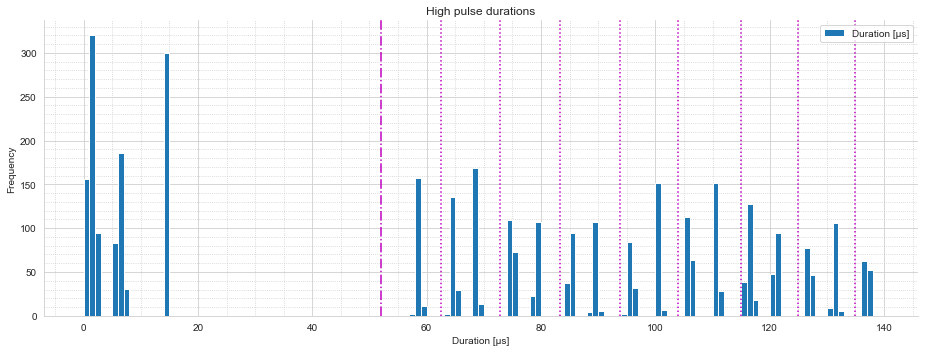

In [19]:
fig, ax = plt.subplots(figsize=(13, 5))
df_high_durations_us.plot.hist(bins=np.arange(0, 140, 1), ax=ax);
for x in sync_peak_end:
    ax.axvline(x, 0, 300, color='m', linestyle=':')
ax.axvline(52, 0, 300, color='m', linestyle='-.')
ax.set_xlabel('Duration [µs]')
ax.set_title('High pulse durations')
ax.grid(b=True, which='minor', linestyle=':')
ax.minorticks_on()
sns.despine()
fig.tight_layout();

We also see a high number of pulses at about 7 … 8 µs and 13 … 14 µs. We can expect these to be the laser sweeps.

Pulse length durations as described [here](https://github.com/widemeadows/LighthouseRedox/blob/master/docs/Light%20Emissions.md):

> Name | skip | data | axis  | length (ticks) | length (µs)
> -----|------|------|-------|----------------|------------
> j0   | 0    | 0    | 0     | 3000           | 62.5
> k0   | 0    | 0    | 1     | 3500           | 72.9
> j1   | 0    | 1    | 0     | 4000           | 83.3
> k1   | 0    | 1    | 1     | 4500           | 93.8
> j2   | 1    | 0    | 0     | 5000           | 104
> k2   | 1    | 0    | 1     | 5500           | 115
> j3   | 1    | 1    | 0     | 6000           | 125
> k3   | 1    | 1    | 1     | 6500           | 135
> 
> Each length represents a combination of 3 bit states:
>
> - The **axis** bit determines the rotation axis for the laser sweep that follows the sync pulse.
> - The **skip** bit determines if the rotor will skip this period and leave its laser off.
> - The **data** bits of consecutive sync pulses of a base station concatenated together yield a data structure called OOTX Frame.
>
> In reality the listed sync pulse lengths should be considered maximum values. The real length should be in a 500 tick window ending at the listed length.
> E.g. sync pulse _j0_ can be 2501-3000 ticks long depending on the position and orientation relative to the base station.
>
> Given a measured pulse length the best match can be found using:
>
> `[skip,data,axis] = (length - 2501) / 500`
>
> Given the 3 bits the pulse length can be calculated:
>
> `length = 3000 + axis*500 + data*1000 + skip*2000`

From the above table, we find that each "tick" represents about 0.0208 µs, or 20.83 ns:

In [20]:
tick_us = (sync_peak_end / np.array(range(3000, 7000, 500))).mean()
tick_us

0.020830375527250526

This duration resembles about 48 MHz, which has a period length of $20.8\bar 3 \,s$.

In [21]:
1/us_to_sec(tick_us)

48006815.7528792

What we know is that 48 MHz is related to USB and the numbers align nicely for the above equations. For a microcontroller running at 72 MHz, we'd use tick values in multiples of 750 instead:

In [22]:
print(np.array(range(3000, 7000, 500)) / 48_000_000 * 72_000_000, '\n',
      500 / 48_000_000 * 72_000_000)

[4500. 5250. 6000. 6750. 7500. 8250. 9000. 9750.] 
 750.0


As for the skew, we allow for a window of 500 ticks at 48 MHz, or about 10.42 µs:

In [23]:
sec_to_us(500 / 48_000_000)

10.416666666666666

Across all values, however, a skew of 10 µs seems to be safer:

In [24]:
np.diff(sync_peak_end)

array([10.4, 10.4, 10.5, 10.2, 11. , 10. , 10. ])

In [25]:
np.sqrt(1.4**2 + 1.5**2), np.sqrt((1.5**2 + 1.7**2) + 3.5**2)

(2.0518284528683193, 4.170131892398609)

In [26]:
OOTXPulse = NamedTuple('OOTXPulse', [('valid', bool), ('name', str), 
                                     ('skip', bool), ('data', int), ('axis', int)])

invalid_pulse = OOTXPulse(valid=False, name='None', skip=False, data=0, axis=0)

ootx_pulses = [
    OOTXPulse(valid=True, name='j-0', skip=False, data=0, axis=0),
    OOTXPulse(valid=True, name='k-0', skip=False, data=0, axis=1),
    OOTXPulse(valid=True, name='j-1', skip=False, data=1, axis=0),
    OOTXPulse(valid=True, name='k-1', skip=False, data=1, axis=1),
    OOTXPulse(valid=True, name='j-2', skip=True, data=0, axis=0),
    OOTXPulse(valid=True, name='k-2', skip=True, data=0, axis=1),
    OOTXPulse(valid=True, name='j-3', skip=True, data=1, axis=0),
    OOTXPulse(valid=True, name='k-3', skip=True, data=1, axis=1)
]

def classify_duration(duration: float) -> OOTXPulse:
    ticks = us_to_sec(duration) * 48_000_000
    pulse_id = int((ticks - 2501) // 500)
    if pulse_id < 0 or pulse_id >= len(ootx_pulses):
        return invalid_pulse
    return ootx_pulses[pulse_id]

classify_duration(93.0)

OOTXPulse(valid=True, name='k-1', skip=False, data=1, axis=1)

In [27]:
df_ootx = df_high_durations_us.apply(lambda row: 
                                     pd.Series(list(classify_duration(row['Duration [µs]'])),
                                               index=['OOTX', 'OOTX Name', 'OOTX Skip', 'OOTX Data', 'OOTX Axis']),
                                     result_type='expand', axis=1)
is_ootx_filter = df_ootx['OOTX'] == True
df_ootx = df_ootx[is_ootx_filter]
df_ootx.head(n=13)

,OOTX,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
1,True,j-1,False,1,0
3,True,k-2,True,0,1
7,True,k-2,True,0,1
9,True,j-0,False,0,0
15,True,k-1,False,1,1
19,True,k-1,False,1,1
21,True,j-3,True,1,0
25,True,j-2,True,0,0
27,True,k-2,True,0,1
31,True,k-3,True,1,1


From the above output we can observe the pattern that stations sweep both their vertical axes, then their horizontal axes (or vice versa) in an alternating pattern. Even though we cannot tell which base station is sending their pulse first, we know that they always pulse in the same order.

In [28]:
def classify_pulse(level: int, duration: float) -> str:
    if level == 0:
        return '-'
    if 0.000005 <= duration <= 0.000015:
        return 'Pulse'
    if 0.000050 <= duration <= 0.000140:
        return 'OOTX'
    return 'Unknown'

df_type = df.apply(lambda row: classify_pulse(row['Level'], row['Duration [s]']), axis=1).to_frame(name='Type').astype('category')

We can now join together all data frames to classify each segment.

In [29]:
df_usec = (df['Duration [s]'] * 1_000_000).to_frame('Duration [µs]')
df_combined = df.join((df_usec, df_type, df_ootx)).drop(columns=['OOTX'])
df_combined.head(n=10)

,Time [s],Level,Duration [s],Duration [µs],Type,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
0,-0.005241,0,0.005241,5241.375000,-,NaN,NaN,NaN,NaN
1,0.000000,1,0.000075,74.583333,OOTX,j-1,False,1.0,0.0
2,0.000075,0,0.000344,344.125000,-,NaN,NaN,NaN,NaN
3,0.000419,1,0.000111,111.041667,OOTX,k-2,True,0.0,1.0
4,0.000530,0,0.002561,2560.500000,-,NaN,NaN,NaN,NaN
5,0.003090,1,0.000014,14.166667,Pulse,NaN,NaN,NaN,NaN
6,0.003104,0,0.005228,5228.375000,-,NaN,NaN,NaN,NaN
7,0.008333,1,0.000107,106.500000,OOTX,k-2,True,0.0,1.0
8,0.008439,0,0.000313,313.000000,-,NaN,NaN,NaN,NaN
9,0.008752,1,0.000059,58.666667,OOTX,j-0,False,0.0,0.0


We also have a handful of values that could not be classified:

In [30]:
df_combined[df_combined.Type == 'Unknown']['Duration [µs]'].describe()

count    571.000000
mean       1.370695
std        0.477098
min        0.458333
25%        0.958333
50%        1.375000
75%        1.708333
max        2.250000
Name: Duration [µs], dtype: float64

When we look at the distribution of values, we find that these are lower than the OOTX frame length even though `OOTX` type classification uses an upper boundary.
Per definition, the area around 10 µs is excluded, but the largest amount of values appears at a duration of 1 µs.
From the data, we find that about 1.1% of our data is "broken".

In [31]:
df_combined.loc[df_combined.Type == 'Unknown', 'Level'].count() / df_combined['Level'].count()

0.07993840123197536

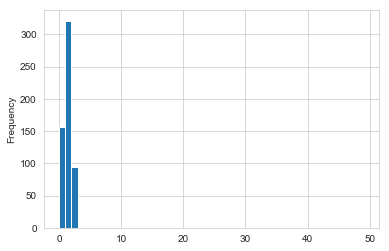

In [32]:
df_combined[df_combined.Type == 'Unknown']['Duration [µs]'].plot.hist(bins=range(0, 50, 1));

Looking at a longer sample, we find that the unknown pulses are indeed in locations where we would expect pulses from the laser sweeps. There are, however, also locations where sweeps are entirely missing.

In [33]:
df_combined[df_combined.Type != '-'].head(n=20)

,Time [s],Level,Duration [s],Duration [µs],Type,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
1,0.000000,1,7.458333e-05,74.583333,OOTX,j-1,False,1.0,0.0
3,0.000419,1,1.110417e-04,111.041667,OOTX,k-2,True,0.0,1.0
5,0.003090,1,1.416667e-05,14.166667,Pulse,NaN,NaN,NaN,NaN
7,0.008333,1,1.065000e-04,106.500000,OOTX,k-2,True,0.0,1.0
9,0.008752,1,5.866667e-05,58.666667,OOTX,j-0,False,0.0,0.0
11,0.013499,1,1.625000e-06,1.625000,Unknown,NaN,NaN,NaN,NaN
13,0.016668,1,1.369167e-04,136.916667,OOTX,NaN,NaN,NaN,NaN
15,0.017087,1,8.916667e-05,89.166667,OOTX,k-1,False,1.0,1.0
17,0.021529,1,1.416667e-06,1.416667,Unknown,NaN,NaN,NaN,NaN
19,0.025002,1,8.495833e-05,84.958333,OOTX,k-1,False,1.0,1.0


At any point, we may miss one OOTX pulse for various reasons, and we may miss a laser sweep. However, by inspecting the average delays between OOTX pulses, we can determine the transition between two subsequently observed peaks:

In [34]:
ootx_1_to_1 = np.array([0.016668 - 0.008333, 0.025002 - 0.016668, 0.033335 - 0.025002]).mean()
ootx_1_to_2 = np.array([0.000419 - 0.000000, 0.008752 - 0.008333, 0.050424 - 0.050003]).mean()
ootx_2_to_1 = np.array([0.008333 - 0.000419, 0.025002 - 0.017087, 0.050003 - 0.042087]).mean()
ootx_2_to_2 = np.array([0.050424 - 0.042087, 0.042087 - 0.033755, 0.025420 - 0.017087]).mean()
np.array([ootx_1_to_1, ootx_1_to_2, ootx_2_to_1, ootx_2_to_2])

array([0.008334  , 0.00041967, 0.007915  , 0.008334  ])

One issue here is that we are not able to tell whether a transition is B-to-B or A/C-to-A/C. The only way to know for sure is to either observe a different OOTX pulse or a sweep.

In [35]:
class OOTXState(Enum):
    OOTX_None = 0
    OOTX_1 = 1,
    OOTX_2 = 2

cycle_length = 0.008333  # seconds
cycle_start = 0
previous_ootx = OOTXState.OOTX_None

previous_ootx_frame_times = collections.deque(maxlen=3)
previous_ootx_frame_times.append(0)

ootx_1_data_bits = bitstring.BitStream()
ootx_2_data_bits = bitstring.BitStream()

for index, row in df_combined.iterrows():
    time = row['Time [s]']
    is_ootx = row['Type'] == 'OOTX'
    is_pulse = row['Type'] == 'Pulse'
    
    if is_ootx:
        ootx_data = row['OOTX Data']
        
        # Hacky fix: OOTX frames that are slightly longer than the max value
        #            will result in an invalid encoding. This only happens
        #            with the largest frames, which encode a 1 it.
        ootx_data = 1 if np.isnan(ootx_data) else int(ootx_data)
        
        previous_ootx_frame_times.append(time)
        previous_ootx_time = previous_ootx_frame_times[-2]
        time_since_last_ootx = time - previous_ootx_time
        
        err_transition_1_to_2 = np.abs(time_since_last_ootx - 0.00041967)
        err_transition_2_to_1 = np.abs(time_since_last_ootx - 0.007915)
        err_transition_n_to_n = np.abs(time_since_last_ootx - 0.008334)
        
        epsilon = 0.001
        transition_1_to_2 = err_transition_1_to_2 <= epsilon
        transition_2_to_1 = err_transition_2_to_1 <= epsilon
        transition_n_to_n = err_transition_n_to_n <= epsilon
        
        if transition_1_to_2:
            # Synchronize clock and state
            cycle_start = previous_ootx_time
            if previous_ootx != OOTXState.OOTX_1:
                print('Lost OOTX 1 frame at time', time, 'in transition from 1 to 2; was', previous_ootx)
            else:
                # Decode current OOTX frame and attach to OOTX 2 buffer
                ootx_2_data_bits.insert(f'0b{ootx_data}')
            previous_ootx = OOTXState.OOTX_2

        elif transition_2_to_1:
            # Synchronize clock and state
            cycle_start = time
            if previous_ootx != OOTXState.OOTX_2:
                print('Lost OOTX 2 frame at time', time, 'in transition from 2 to 1; was', previous_ootx)
            else:
                # Decode current OOTX frame and attach to OOTX 1 buffer
                ootx_1_data_bits.insert(f'0b{ootx_data}')
            previous_ootx = OOTXState.OOTX_1

        elif transition_n_to_n:
            # If clock is synchronized, determine frame; otherwise drop
            if previous_ootx == OOTXState.OOTX_1:
                print('Lost OOTX 2 frame at time', time, 'in long transition; was', previous_ootx)
                ootx_1_data_bits.insert(f'0b{ootx_data}')
            elif previous_ootx == OOTXState.OOTX_2:
                print('Lost OOTX 1 frame at time', time, 'in long transition; was', previous_ootx)
                ootx_2_data_bits.insert(f'0b{ootx_data}')

Lost OOTX 1 frame at time 0.0 in transition from 1 to 2; was OOTXState.OOTX_None
Lost OOTX 1 frame at time 0.000418708333333 in transition from 1 to 2; was OOTXState.OOTX_2


In [36]:
len(ootx_1_data_bits), len(ootx_2_data_bits)

(1199, 1199)

Let's inspect the data collected for the first base station:

In [37]:
ootx_1_data_bits.bin

'011011010101011101010101010101000111011001111101111011011101111001010101010101010100011101000101010111010110011001111101111101110111111011110100011011100101111101110100110001010100010111000111010101100111111011000110011001010111010111001110010101011111110101000101010001110101011111101110011011000100111011110111011011011111111111110100011101101100011011101100111101010100110101010101010101011100110111110110111001110111110001010101010101010101110101010101011101011101110011100111110111011111111011000100111111010110110111000111010001010100011001011100010011001110111101011101110101011101011101101101010101111110010101010100010011010101111011101100111101000111111111011101111101101110111111010100110111100100111011110110110101010111010101010101010001110110011111011110110111011110010101010101010101000111010001010101110101100110011111011111011101111110111101000110111001011111011101001100010101000101110001110101011001111110110001100110010101110101110011100101010111111101010001010100011101010111111

Searching for the synchronization sequence yields nothing.

In [38]:
ootx_1_data_bits.find('0b000000000000000001')

()

The second base station did start a sequence however:

In [39]:
ootx_2_data_bits.find('0b000000000000000001')

(122,)

In [40]:
sequence = ootx_2_data_bits[122:]
sequence.bin

'000000000000000001001000010000000010000011001101101111111011110011011010001010001001110001010100101111101100010001010101110100001000110111010011000010011100000100000010011101001010001100011010111010010100111111101011111111011000101000000110100000010100100101000100101110111001000010000110110010000000000010100000000000000001111010111100111110101111101100101100000000000000000100100001000000001000001100110110111111101111001101101000101000100111000101010010111110110001000101010111010000100011011101001100001001110000010000001001110100101000110001101011101001010011111110101111111101100010100000011010000001010010010100010010111011100100001000011011001000000000001010000000000000000111101011110011111010111110110010110000000000000000010010000100000000100000110011011011111110111100110110100010100010011100010101001011111011000100010101011101000010001101110100110000100111000001000000100111010010100011000110101110100101001111111010111111110110001010000001101000000101001001010001001011101110010000100

In [41]:
seq_length = sequence[18:18+16].unpack('uintle:16')[0]
seq_length

33

The bit after the length (i.e. the 17th bit in the sequence) is expected to be a padding `1`:

In [42]:
sequence[18+16:18+17].bin

'1'

In [43]:
sequence = sequence[18+17:]
sequence

BitStream('0x066dfde6d144e2a5f622ae846e984e0813a518d74a7f5fec50340a4a25dc843640050000f5e7d7d9600009080419b7f79b45138a97d88aba11ba6138204e94635d29fd7fb140d02928977210d900140003d79f5f65800024201066dfde6d144e2a5f622ae846e984e0813a518d74a7f5fec50340a4a25dc84364005000...') # length=1042

In [44]:
bytes_ = []
bytes_to_read = 16
payload_sequence = sequence

for i in range(seq_length):
    segment = payload_sequence[0:8]
    payload_sequence = payload_sequence[8:]
    
    value = segment.unpack('uint:8')[0]
    bytes_.append(value)

    bytes_to_read -= 8
    if bytes_to_read == 0:
        bytes_to_read = 16
        assert payload_sequence[0] == True
        payload_sequence = payload_sequence[1:]

In [45]:
bytes_ = bytes(bytes_)
len(bytes_), bytes_

(33,
 b'\x06m\xfb\xcdE\x13\x15/b*\xd0\x8d\xa6\x13\x04\t\xa5\x18\xae\x94\xfd\x7fb\x81@\xa4D\xbb!\r \x02\x00')

Remove padding byte and sync bit:

> If the number of payload bytes is not a multiple of 2, a padding byte (zero-byte) is added so that the Payload field can always end with a Sync Bit.

In [46]:
if bytes_to_read == 8:
    assert len(bytes_) % 2 != 0
    payload_sequence = payload_sequence[9:]

We're now left with the remainder of the current sequence and are able to identify another sequence start immediately after it.

In [52]:
sequence = payload_sequence
sequence.bin, sequence.find('0b00000000000000001')

('111010111100111110101111101100101100000000000000000100100001000000001000001100110110111111101111001101101000101000100111000101010010111110110001000101010111010000100011011101001100001001110000010000001001110100101000110001101011101001010011111110101111111101100010100000011010000001010010010100010010111011100100001000011011001000000000001010000000000000000111101011110011111010111110110010110000000000000000010010000100000000100000110011011011111110111100110110100010100010011100010101001011111011000100010101011101000010001101110100110000100111000001000000100111010010100011000110101110100101001111111010111111110110001010000001101000000101001001010001001011101110010000100001101100100000000000101000000000000000011110101111001111101011111011001011000',
 (35,))

The CRC32 checksum is 32 bit long; since a Sync Bit is placed every 16 bits, the total length is 34 bits, which explains why we observe a sequence start at position 35 in the output above.

We can now extract the CRC32 checksum and convert it to an integer for visualization convenience.

In [48]:
crc32_seq = sequence[0:16] + sequence[17:33]
assert sequence[16] == True
assert sequence[13] == True

crc32 = crc32_seq.unpack('uintle:32')[0]
bitstring.BitArray(pack('<I', crc32)).bin, crc32

('11101011110011110101111101100101', 1700777963)

When we compare this value against the CRC32 checksum calculated directly from the bytes, we find that the values match.

In [49]:
crc32_calculated = binascii.crc32(bytes(bytes_))
bitstring.BitArray(pack('<I', binascii.crc32(bytes(bytes_[0:-1])) & 0xffffffff)).bin, crc32_calculated

('01111110010111010111110011100000', 1700777963)

Knowing that the sequence is correct, we can extract the individual components. Note that, like before, all values are Little-Endian (LSB first).

In [107]:
values = unpack('<HIHHHHBB', bytes_[0:16])
fw_version, id_, fcal_0_phase, fcal_1_phase, fcal_0_tilt, fcal_1_tilt, sys_unlock_count, hw_version = values

values = unpack('<eebbbeeeeBB', bytes_[16:33])
fcal_0_curve, fcal_1_curve, accel_dir_x, accel_dir_y, accel_dir_z, fcal_0_gibphase, fcal_1_gibphase, fcal_0_gibmag, fcal_1_gibmag, mode_current, sys_faults = values

fw_version_hi = (fw_version & 0xff00) >> 8
fw_version_lo = fw_version & 0xff

> The current **protocol version** is 6. For older protocol versions the data structure might look different.
> E.g. In version 4 and 5 the data block is only 31 bytes long. The last two fields are missing.

> The ID is a (pseudo-)random 32-bit number. The current implementation uses the CRC32 of the 128-bit MCU UID.

In [78]:
print('Station ID           ', id_)
print('FW version           ', fw_version_hi, 'protocol', fw_version_lo)
print('HW version           ', hw_version)
print('Current mode         ', mode_current)
print('Unlock count         ', sys_unlock_count)

Station ID            323341819
FW version            109 protocol 6
HW version            9
Current mode          2
Unlock count          4


> The flags in **sys.faults** are: 2=Unknown, 4=Laser0, 8=Laser1, 16=Motor0, 32=Motor1 [UNCONFIRMED]

In [79]:
print('Fault detected       ', sys_faults)

Fault detected        0


> The factory calibration **fcal** provides information about nonidealities in the base station's laser emmisions caused by the production process. **fcal.n.phase** corrects the constant phase offset

In [76]:
print('Rotor 0 phase        ', fcal_0_phase)
print('Rotor 0 tilt         ', fcal_0_tilt)
print('Rotor 0 curve        ', fcal_0_curve)
print('Rotor 0 gibbous phase', fcal_0_gibphase)
print('Rotor 0 gibbous mag. ', fcal_0_gibmag)

print('Rotor 1 phase        ', fcal_1_phase)
print('Rotor 1 tilt         ', fcal_1_tilt)
print('Rotor 1 curve        ', fcal_1_curve)
print('Rotor 1 gibbous phase', fcal_1_gibphase)
print('Rotor 1 gibbous mag. ', fcal_1_gibmag)

Rotor 0 phase         12053
Rotor 0 tilt          36304
Rotor 0 curve         0.0022678375244140625
Rotor 0 gibbous phase 2.251953125
Rotor 0 gibbous mag.  0.01119232177734375
Rotor 1 phase         10850
Rotor 1 tilt          5030
Rotor 1 curve         -0.0011425018310546875
Rotor 1 gibbous phase 4.640625
Rotor 1 gibbous mag.  0.00791168212890625


The orientation vector **accel.dir\_[xyz]** is not a unit vector and its length has no meaning. It is scaled in a way that its biggest/smallest component always is +127/-127.

In [108]:
print('Acceleration X       ', accel_dir_x)
print('Acceleration Y       ', accel_dir_y)
print('Acceleration Z       ', accel_dir_z)

Acceleration X        -3
Acceleration Y        127
Acceleration Z        98


In [210]:
accel = np.array([accel_dir_x, accel_dir_y, accel_dir_z], dtype=np.float32)
accel /= np.linalg.norm(accel)
accel

array([-0.01869821,  0.7915577 ,  0.6108083 ], dtype=float32)

The base station appears to be laid out in a right-handed coordinate system with

- X pointing right (left when looking _at_ the base station)
- Y pointing up
- Z pointing back (negative Z axis is forward)

![](images/base-station-coordinate-system.png)

(Image: EE 267 Virtual Reality Course Notes: 6-DOF Pose Tracking with the VRduino, Gordon Wetzstein, 2017)

In [219]:
def plot_accel(accel: np.ndarray, elev: float=30, azim: float=125):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs=[0, accel[0]], ys=[0, accel[2]], zs=[0, accel[1]],
            linewidth=2, label='Acceleration', linestyle='-.')
    ax.plot(xs=[0, -accel[0]], ys=[0, -accel[2]], zs=[0, -accel[1]],
            linewidth=5, label='Forward')
    ax.plot(xs=[0, 1], ys=[0, 0], zs=[0, 0], label='X', color='r', linestyle=':')
    ax.plot(xs=[0, 0], ys=[0, 1], zs=[0, 0], label='Z', color='b', linestyle=':')
    ax.plot(xs=[0, 0], ys=[0, 0], zs=[0, 1], label='Y', color='g', linestyle=':')
    ax.legend()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev, azim)
    ax.invert_yaxis()
    fig.tight_layout();

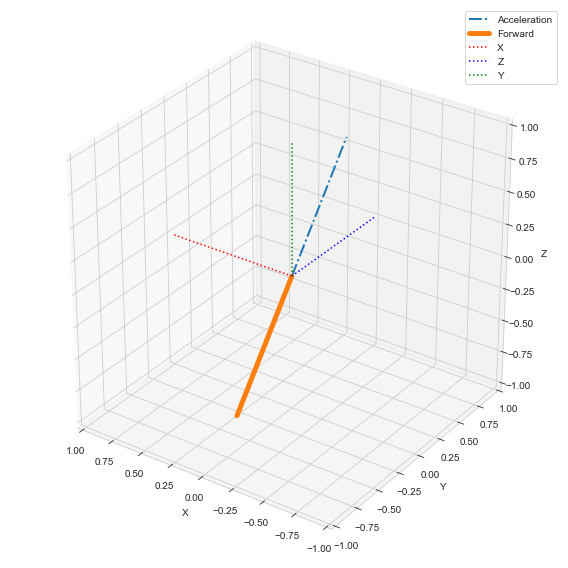

In [220]:
plot_accel(accel)

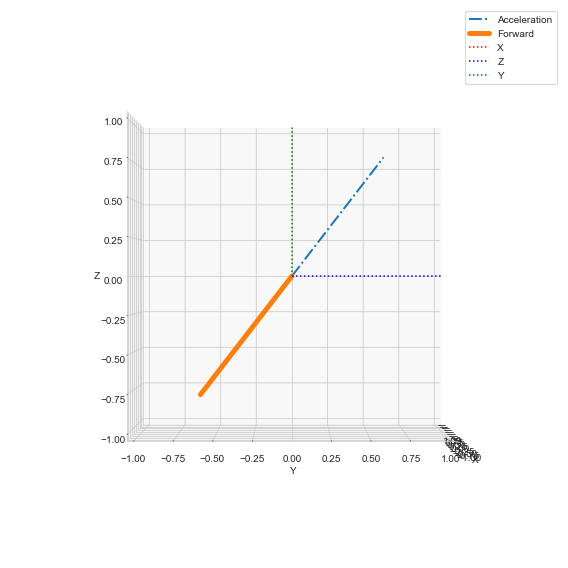

In [225]:
plot_accel(accel, 0, 180)

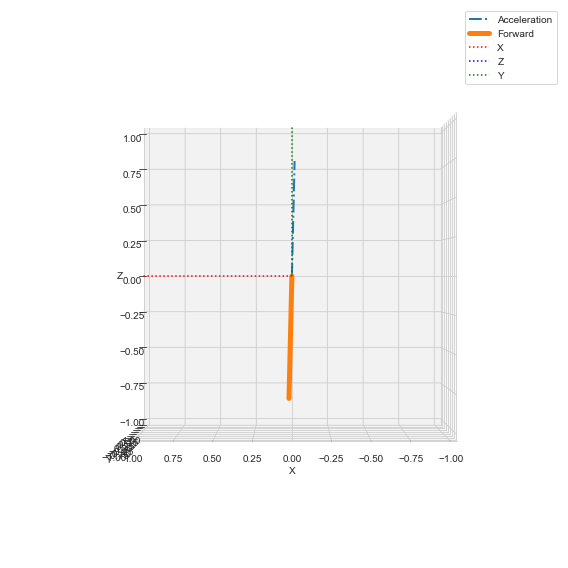

In [226]:
plot_accel(accel, 0, 90)

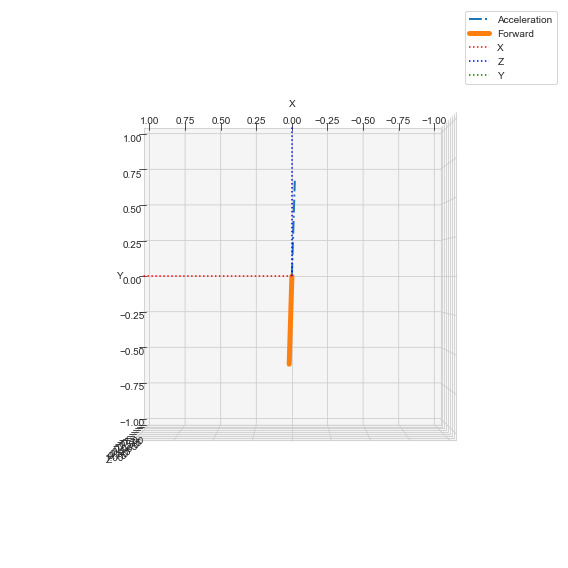

In [230]:
plot_accel(accel, 90, 90)